## Simulate/Import Data

In [1]:
# Choose the dataset
dataset_choice = "telemega"  # Options: simulation, telemetrum, telemega

In [2]:
# Import libraries and functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

import flight_simulation as fsim
import helper_functions as hfunc
import rocket_classes as rktClass
import constants as con
import data_processing as dp
import plotting_functions as pf
from configs import Prometheus, Hyperion

In [3]:
if dataset_choice == "simulation":
    # Simulate flight using rocket configuration
    rocket = rktClass.Rocket(**Hyperion)

    # Simulate the flight
    (
        dataset,
        liftoff_index,
        launch_rail_cleared_index,
        burnout_index,
        apogee_index,
    ) = fsim.simulate_flight(rocket)

    A_rocket = rocket.A_rocket
    Cd_rocket_at_Re = rocket.Cd_rocket_at_Re

elif dataset_choice == "telemetrum":
    data_type = "telemetrum"
    file_path = "Prometheus-flight-data/2022-06-24-serial-5115-flight-0001.csv"
    dataset = dp.import_and_clean_data(file_path, data_type)
    dataset = dp.calculate_aerodynamic_parameters(dataset, Prometheus)
    # Cut data to only include ascent. Last 5 points taken off so that the affects due to chute deployment at apogee aren't considered
    apogee_index = dataset["height"].idxmax() - 5
elif dataset_choice == "telemega":
    data_type = "telemega"
    file_path = "Prometheus-flight-data/2022-06-24-serial-6583-flight-0003.csv"
    dataset = dp.import_and_clean_data(file_path, data_type)
    dataset = dp.calculate_aerodynamic_parameters(dataset, Prometheus)
    # Cut data to only include ascent. Last 5 points taken off so that the affects due to chute deployment at apogee aren't considered
    apogee_index = dataset["height"].idxmax() - 5
else:
    raise ValueError("Invalid dataset_choice selected")

## Ascent Overview

We don't care about what happens after apogee; that's when our job finishes. We'll want to finish retracting by apogee, but at that point we're finished

In [4]:
imperial = True

In [5]:
if dataset_choice != "simulation":
    dataset["v_y"] = dataset["speed"]
    dataset["v_x"] = 0
    dataset["a_y"] = dataset["acceleration"]
    dataset["a_x"] = 0

    # Set first two indices
    liftoff_index = 0
    for i in range(len(dataset)):
        if dataset["height"][i] > 5.2 * np.cos(np.deg2rad(80)):
            launch_rail_cleared_index = i
            break

    from configs import Prometheus_Cd_function as Cd_rocket_at_Re
    rocket = rktClass.Rocket(**Prometheus)
    # burnout_index is set to the later of one of two events:
    #   1) accel_plus_Fg_minus_drag is less than 5 m/s^2. Would've used zero, but the data isn't perfect so it doesn't quite get there
    #   2) time of max velocity, which helps with messier data like the TeleMega's
    dataset["drag_force"] = (
        dataset["q"]
        * dataset["reynolds_num"].apply(lambda x: Cd_rocket_at_Re(x))
        * rocket.A_rocket
    )
    dataset["accel_plus_Fg_minus_drag"] = (
        dataset["a_y"] + con.F_gravity + dataset["drag_force"] / rocket.dry_mass
    )
    burnout_index = max(
        dataset["time"][
            dataset["accel_plus_Fg_minus_drag"].apply(lambda x: x < 5)
        ].idxmin(),
        dataset["speed"].idxmax(),
    )

time = dataset["time"][:apogee_index]
height = dataset["height"][:apogee_index].copy()
speed = dataset["speed"][:apogee_index].copy()
v_y = dataset["v_y"][:apogee_index].copy()
a_y = dataset["a_y"][:apogee_index].copy()
a_x = dataset["a_x"][:apogee_index].copy()
g_force = np.sqrt(a_y**2 + a_x**2) / con.F_gravity
# Set vertical velocity and acceleration to the measured totals (sensors didn't record vertical and horizontal separately)

unit = "m"
if imperial:
    height *= con.m_to_ft_conversion
    speed *= con.m_to_ft_conversion
    v_y *= con.m_to_ft_conversion
    a_y *= con.m_to_ft_conversion
    a_x *= con.m_to_ft_conversion
    unit = "ft"

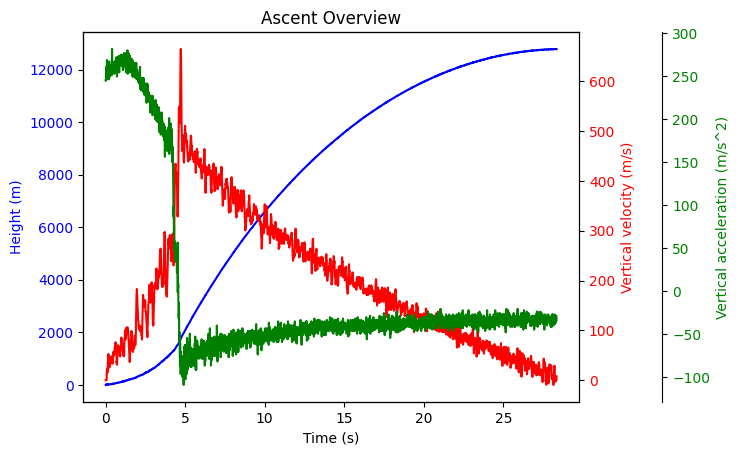

,Time (s),Height (ft),Vertical velocity (ft/s),Speed (ft/s),Vertical accel (ft/s^2),G-force (g),Re*10^7,Mach,q (kPa)
Liftoff,0.00,1.54,0.00,0.00,244.52,7.60,0.00,0.00,0.00
Off Launch Rail,0.01,11.52,0.00,0.00,244.52,7.60,0.00,0.00,0.00
Max-g Force,0.40,33.60,37.09,37.09,281.53,8.75,0.13,0.03,0.06
Max Re,4.72,1759.12,664.94,664.94,-94.91,2.95,2.24,0.58,19.08
Max q,4.72,1759.12,664.94,664.94,-94.91,2.95,2.24,0.58,19.08
Max Speed,4.72,1759.12,664.94,664.94,-94.91,2.95,2.24,0.58,19.08
Burnout,4.72,1759.12,664.94,664.94,-94.91,2.95,2.24,0.58,19.08
Apogee,28.35,12774.08,7.78,7.78,-33.79,1.05,-0.03,-0.01,0.00


In [6]:
# Plot Ascent
pf.plot_ascent(time, height, speed, v_y, a_y, "m")


# Create table of parameters at key flight events
parameters_at_flight_events = pf.create_flight_event_table(
    time=time,
    height=height,
    v_y=v_y,
    speed=speed,
    a_y=a_y,
    g_force=g_force,
    reynolds_num=dataset["reynolds_num"],
    dataset=dataset,
    liftoff_index=liftoff_index,
    launch_rail_cleared_index=launch_rail_cleared_index,
    burnout_index=burnout_index,
    apogee_index=apogee_index,
    unit=unit,
)

display(parameters_at_flight_events)

# For the simulation, plot aerodynamic parameters over the ascent
if dataset_choice == "simulation":
    pf.plot_aerodynamics(
        time,
        height,
        speed,
        dataset["q"],
        dataset["reynolds_num"],
        dataset["air_density"],
        "m",
    )

## Airbrakes Simulation

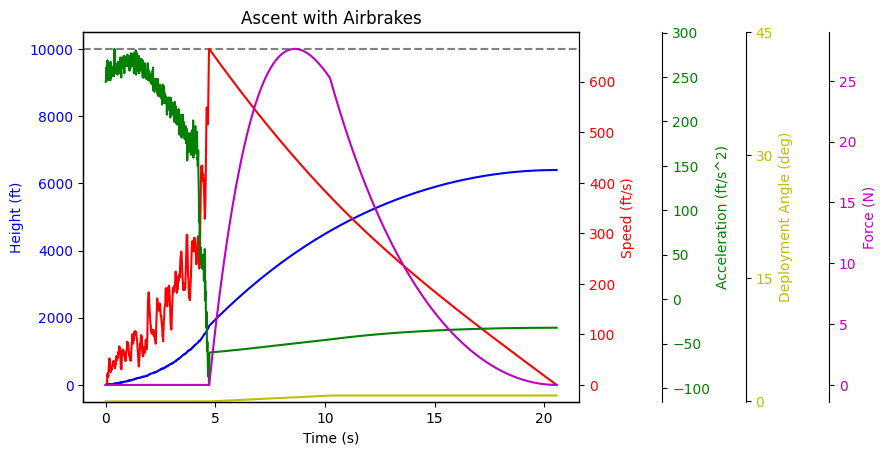

,Time (s),Height (ft),Speed (ft/s),Accel (ft/s^2),G-force (g)
Apogee with Airbrakes,20.57,6396.274941,0.089341,-32.174054,1.00
Apogee without Airbrakes,28.35,12774.080000,7.780000,-33.790000,1.05
Delta,-7.78,-6377.805059,-7.690659,1.615946,-0.05
% Delta,-27.44,-49.930000,-98.850000,-4.780000,-4.76


5.5099999999998825

In [7]:
# Simulate airbrakes flight

# Set flightpath until airbrake deployment as identical
airbrake_deployment = burnout_index + 1
pre_brake_flight = dataset.head(airbrake_deployment).copy()

# Set timestep based on dataset
if dataset_choice in ["telemetrum", "telemega"]:
    timestep = 0.01
else:
    timestep = 0.001

# Using the default airbrakes, the current airbrakes model in configs.py. Can set up others
ascent, time_of_max_deployment = fsim.simulate_airbrakes_flight(
    pre_brake_flight, rocket=rocket, timestep=timestep
)

# Analyze ascent and plot with airbrakes
pf.plot_airbrakes_ascent(ascent, unit)

# Display table of parameters at apogee
display(pf.display_apogee_parameters_table(ascent, parameters_at_flight_events, unit))


dataset["time"].iloc[airbrake_deployment]
time_of_max_deployment
total_deploy_time = time_of_max_deployment - dataset["time"].iloc[airbrake_deployment] 
display(total_deploy_time)



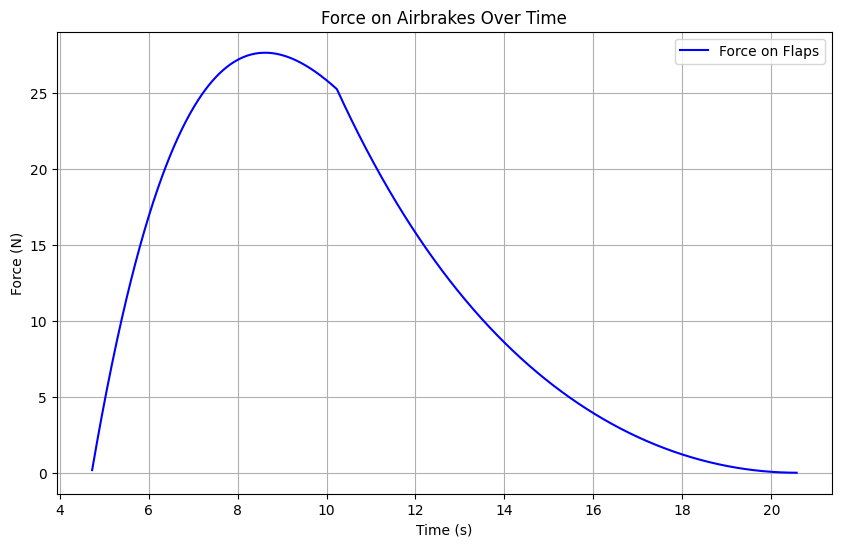

In [8]:
import math

flap_h = 65 # mm
flap_w = 35 # mm
flap_A = flap_h * flap_w

# taking  dataset["q"], and dividing by the flap area of 21.5 cm^2 to get the force on the flaps times sine of the angle of the flaps
force = ascent["q"].iloc[airbrake_deployment:] * 0.001 * 0.001 * flap_A * np.sin(ascent["deployment_angle"]) * 3
time_for_plot = ascent["time"].iloc[airbrake_deployment:]


# Plotting
plt.figure(figsize=(10, 6))  # Customize the figure size as needed
plt.plot(ascent["time"], force, label='Force on Flaps', color='blue')  # Customize color and label as needed
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')  # Assuming the force is in Newtons
plt.title('Force on Airbrakes Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
def calculate_lead_screw_efficiency(lead, diameter, coefficient_of_friction, input_unit='imperial'):
    """
    Calculate the efficiency of a lead screw considering different materials for screw and nut.

    :param lead: The lead of the screw (distance the nut moves per screw revolution).
    :param diameter: The nominal diameter of the screw.
    :param coefficient_of_friction: The coefficient of friction between screw and nut materials.
    :param input_unit: 'imperial' or 'metric'.
    :return: Efficiency of the lead screw.
    """
    # Convert all inputs to imperial units for calculation
    if input_unit == 'metric':
        lead = lead * 0.0393701  # Convert lead to inches
        diameter = diameter * 0.0393701  # Convert diameter to inches

    # Calculate pitch diameter, assuming it's close to the nominal diameter
    pitch_diameter = diameter

    # Calculate the lead angle
    lead_angle = math.atan(lead / (math.pi * pitch_diameter))

    # Calculate angle of friction
    angle_of_friction = math.atan(coefficient_of_friction)

    # Calculate efficiency
    efficiency = math.tan(lead_angle) / math.tan(lead_angle + angle_of_friction)

    return efficiency  # Fractional efficiency

def calculate_pitch(threads_per_pitch, input_unit='imperial', output_unit='imperial'):
    """
    Calculate the pitch of a lead screw.

    :param threads_per_pitch: Threads per inch if imperial, pitch in mm if metric.
    :param input_unit: 'imperial' or 'metric'.
    :param output_unit: 'imperial' (threads per inch) or 'metric' (pitch in mm).
    :return: Pitch of the lead screw in the desired unit.
    """
    if input_unit == 'imperial':
        if output_unit == 'metric':
            # Convert threads per inch to pitch in mm (1 inch = 25.4 mm)
            pitch = 25.4 / threads_per_pitch
        else:
            pitch = threads_per_pitch  # Already in threads per inch
    else:  # input is metric
        if output_unit == 'imperial':
            # Convert pitch in mm to threads per inch (1 inch = 25.4 mm)
            pitch = 25.4 / threads_per_pitch
        else:
            pitch = threads_per_pitch  # Already in mm

    return pitch

# From : https://www.mcmaster.com/95075A340/ (PET Plastic Externally Threaded Precision Acme Nut)
coefficient_of_friction = 0.22  # Estimated for steel on PET plastic
# from: https://www.mcmaster.com/99030A985/ (1/4 20 1018 Carbon Steel Precision Acme Lead Screw)

'''
lead = 0.05 # imperial
diameter = 0.25 # imperial
threads_per_pitch = 20 # imperial
'''
# from: https://www.mcmaster.com/99030A981/ (1/4 16 1018 Carbon Steel Precision Acme Lead Screw)
lead = 0.063 # imperial
diameter = 0.25 # imperial
threads_per_pitch = 16 # imperial


lead_screw_pitch = calculate_pitch(threads_per_pitch, input_unit='imperial', output_unit='metric')
print("Lead screw pitch: ", lead_screw_pitch)
lead_screw_efficiency = calculate_lead_screw_efficiency(lead, diameter, coefficient_of_friction, 'imperial')
print("Lead screw efficiency: ", lead_screw_efficiency)

Lead screw pitch:  1.5875
Lead screw efficiency:  0.262474505690809


In [10]:
def calculate_driving_torque(load, lead, efficiency):
    """
    Calculate the driving torque for a screw.
    
    Parameters:
    load (float): The load in pounds (lb).
    lead (float): The screw lead in inches/turn.
    efficiency (float): The efficiency of the screw.
    
    Returns:
    float: The driving torque in pound-inches.
    """
    return (load * lead) / (2 * math.pi * efficiency)

def calculate_holding_torque(load, lead, efficiency):
    """
    Calculate the holding torque for a screw.
    
    Parameters:
    load (float): The load in pounds (lb).
    lead (float): The screw lead in inches/turn.
    efficiency (float): The efficiency of the screw.
    
    Returns:
    float: The holding torque in pound-inches.
    """
    return (load * lead * efficiency) / (2 * math.pi)

def pound_inches_to_kg_cm(pound_inches):
    """
    Convert pound-inches to kilogram-centimeters.
    
    Parameters:
    pound_inches (float): The torque in pound-inches.
    
    Returns:
    float: The torque in kilogram-centimeters.
    """
    conversion_factor = 0.86796165979664
    return pound_inches * conversion_factor

def kg_cm_to_pound_inches(kg_cm):
    """
    Convert kilogram-centimeters to pound-inches.
    
    Parameters:
    kg_cm (float): The torque in kilogram-centimeters.
    
    Returns:
    float: The torque in pound-inches.
    """
    conversion_factor = 0.86796165979664
    return kg_cm / conversion_factor

In [11]:
import pandas as pd
import numpy as np

# Applied force calculation
f_applied = force * np.sin(np.deg2rad(45))
#print("Max applied force: ", max(f_applied), "N")


# Angle of the blue member with the horizontal
angle_degrees = 22
angle_radians = math.radians(angle_degrees)

# Friction coefficient (this is a rough estimate and should be determined experimentally or from literature)
friction_coefficient = 0.1  # Typical value for metal on metal contact

# Apply the friction coefficient to the force, viewing it as a loss from POV of servo
f_applied *= (1 + friction_coefficient)

# Recalculate force components considering friction
f_applied_x = f_applied * math.cos(angle_radians)
f_applied_y = f_applied * math.sin(angle_radians)

# The factor for determining where the equivalent applied force is located of the distributed the force along the member DC
distribution_factor = 0.5  # Assuming midpoint due to symmetry and results of FEA

# Adjust forces at Point C of member DC considering the distribution factor
f_applied_DC_cx = -f_applied_x * distribution_factor
f_applied_DC_cy = -f_applied_y * distribution_factor

# Since the system is symmetric, the forces at Point C of member CB will be the same but in the opposite direction
f_applied_CB_cx = -f_applied_DC_cx
f_applied_CB_cy = -f_applied_DC_cy

# The forces will be the same along the members since they are two-force members in this model
f_applied_CB_bx = f_applied_CB_cx
f_applied_CB_by = f_applied_CB_cy

f_applied_BA_bx = f_applied_CB_bx
f_applied_BA_by = f_applied_CB_by

# The force at Point A (attachment/contact point on the lead screw)
f_x_result = -f_applied_BA_bx
f_y_result = -f_applied_BA_by


# Assuming 'lead' and 'lead_screw_efficiency' are known
# Convert force back to Newtons for torque calculation and then to load in pounds
load_lbs = f_y_result / -4.4482216  # Convert from N to lbs
print(max(load_lbs))
# Calculate torques for each force value
driving_torque_lbs_in = calculate_driving_torque(load_lbs, lead, lead_screw_efficiency)
holding_torque_lbs_in = calculate_holding_torque(load_lbs, lead, lead_screw_efficiency)

# Convert torques to kg-cm
driving_torque_kg_cm = pound_inches_to_kg_cm(driving_torque_lbs_in)
holding_torque_kg_cm = pound_inches_to_kg_cm(holding_torque_lbs_in)




nan


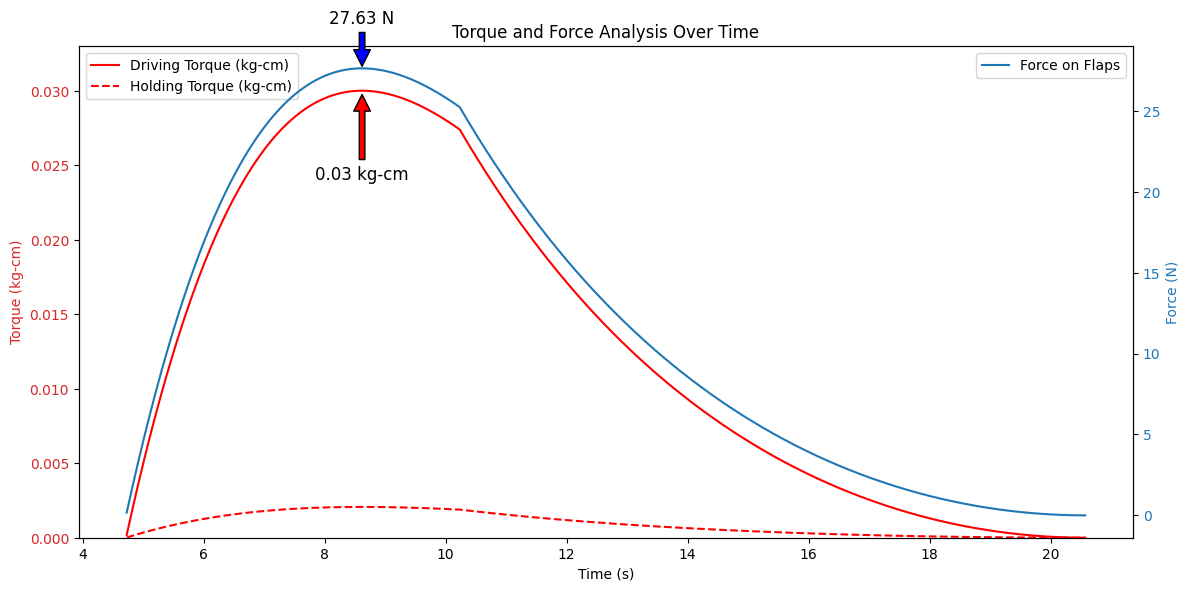

In [12]:
# Create a DataFrame for easy plotting
torque_data = pd.DataFrame({
    'time': time_for_plot,
    'driving_torque_kg_cm': driving_torque_kg_cm,
    'holding_torque_kg_cm': holding_torque_kg_cm,
    'force': force,
})

# Find the indices of the maxima for force and torques
max_force_idx = torque_data['force'].idxmax()
max_driving_torque_idx = torque_data['driving_torque_kg_cm'].idxmax()
max_holding_torque_idx = torque_data['holding_torque_kg_cm'].idxmax()

# Extract the maxima values and corresponding times
max_force = torque_data['force'][max_force_idx]
max_force_time = torque_data['time'][max_force_idx]
max_driving_torque = torque_data['driving_torque_kg_cm'][max_driving_torque_idx]
max_driving_torque_time = torque_data['time'][max_driving_torque_idx]
max_holding_torque = torque_data['holding_torque_kg_cm'][max_holding_torque_idx]
max_holding_torque_time = torque_data['time'][max_holding_torque_idx]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# First y-axis for the torque
color = 'tab:red'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Torque (kg-cm)', color=color)
ax1.plot(torque_data['time'], torque_data['driving_torque_kg_cm'], label='Driving Torque (kg-cm)', color='r')
ax1.plot(torque_data['time'], torque_data['holding_torque_kg_cm'], label='Holding Torque (kg-cm)', color='r', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Annotations for maxima on the left y-axis
ax1.annotate(f'{max_driving_torque:.2f} kg-cm',
             xy=(max_driving_torque_time, max_driving_torque),
             xytext=(max_driving_torque_time, max_driving_torque*0.8),
             arrowprops=dict(facecolor='red', shrink=0.05),
             horizontalalignment='center',
             fontsize='large')


# Create a second y-axis for the force
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Force (N)', color=color)
ax2.plot(torque_data['time'], torque_data['force'], label='Force on Flaps', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Annotation for maxima on the right y-axis
ax2.annotate(f'{max_force:.2f} N',
             xy=(max_force_time, max_force),
             xytext=(max_force_time, max_force*1.1),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             horizontalalignment='center',
             fontsize='large')

ax1.set_ylim([0, torque_data['driving_torque_kg_cm'].max() * 1.1])  # 10% more than max

plt.title('Torque and Force Analysis Over Time')
fig.tight_layout()  # To ensure there's no overlap
plt.show()